
# 데이터 파일 압출 풀기
-----
* 우클릭 시 경로 복사 가능.



In [11]:
from google.colab import drive #내 드라이브와 연동
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Kaggle_Study


In [3]:
%cd "/content/drive/MyDrive/Colab Notebooks/Kaggle_Study" # %cd 압축을 풀 경로

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Kaggle_Study # %cd 압축을 풀 경로'
/content


In [5]:
#압출 파일 경로 
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/Kaggle_Study/영화 관객수.zip" 

replace submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 


# 목표
-----
* 영화 관객수 예측하기
* 나머지 제목, 배급사 등에 대한 데이터는 입력값이 됨.    
🎯 제목, 배급사 등 주어진 정보를 바탕으로 관객수 예측하기



## 데이터 다루기
----
* **좋은 데이터**란?


> 한쪽으로 치우치지 않고，불필요한 정보를 가지 
고 있지 않으며. 왜곡되지 않은 데이터.

* 머신러닝과 딥러닝에서 사용할 수 있게 잘 정제된 데이터 형식으로 바꾸는 과정 필요 

1.   속성과 클래스를 먼저 구분하기
2.   데이터 시각화하여 데이터 파악하기




### EDA
> pandas를 이용하여 데이터 조사



In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')


In [12]:
train.info() #데이터의 전반적인 정보 확인(개수, 타입, null의 개수)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


7번 Column(dir_prev_bfnum)이 600개가 아니므로 null값이 존재한다.

In [13]:
train.head(5) #첫 다섯 줄의 데이터 불러옴.

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [14]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


<Axes: >

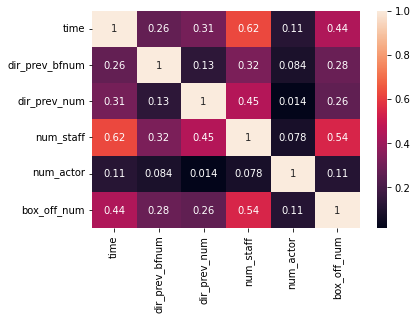

In [15]:
#시각화
import seaborn as sns

sns.heatmap(train.corr(),annot=True)

예측하고자 하는 box_off_num과 상관관계가 높은 것들을 확인.
1. num_staff
  스태프가 많을수록 관객수가 높을 것이다.
2. time

### 데이터 가공하기
---


> 결측값의 데이터 등 한 번 더 가공하는 과정이 필요함. 데이터를 가공할 때 관객수를 예측하는 목표 잊지 않기!따라서 다른 정보와 관객수 간의 관계를 중점에 놓아야 함.

* 누락 데이터 처리하기(데이터 분석 189pg)
1. isnull notnull 함수      
  누락된 데이터 조회
2. dropna 함수   
  누락된 데이터가 있는 행과 열 제외     
3. fillna 함수
  누락된 데이터 값 채우기


#### 결측값 제거

In [7]:
#결측치가 많은 dir_prev_bfnum의 데이터 제거 - 데이터 분석 189 누락 데이터 처리
train=train.dropna(axis=1)
train.info()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,0,431,4,2192525


In [8]:
train.info() #결측치가 잘 제거되었는지 확인한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          600 non-null    object
 1   distributor    600 non-null    object
 2   genre          600 non-null    object
 3   release_time   600 non-null    object
 4   time           600 non-null    int64 
 5   screening_rat  600 non-null    object
 6   director       600 non-null    object
 7   dir_prev_num   600 non-null    int64 
 8   num_staff      600 non-null    int64 
 9   num_actor      600 non-null    int64 
 10  box_off_num    600 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 51.7+ KB


#### 결측값 채우기

In [18]:
#결측치에 대한 정보 채우기
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [20]:
#nan일 때 dir_prev_num가 전부 0이므로, 이전 작품이 없엇다고 생각.
train['dir_prev_bfnum'].fillna(0,inplace=True)

In [21]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0.00,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,0.00,0,431,4,2192525


In [23]:
#test 데이터도 채우기
test['dir_prev_bfnum'].fillna(0,inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  243 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


## 모델링
----


1.   모델링하기 전에 앞서, 모든 데이터를 기계가 이해할 수 있는 **수치로 변**환해주어야 한다.

> 가장 먼저, **수치형 데이터**로    변환해주고    
그 다음 가변수화를 하기 위한   **원핫인코딩**을 진행해야 한다.


2.   항목 추가



###모델 구축

LightGBM

*   부스팅모델로 순차적으로 모델이 만들어짐.
*   이때 기존 모델이 못 맞춘 문제에 가중치를 더 주어 발전된 모델을 형성함.


In [29]:
import lightgbm as lgb #사용할 모델

In [30]:
#관객수는 0~999999999 즉 연속적인 값이기 때문에 Regressor로 이용함.
model=lgb.LGBMRegressor(random_state=777,n_estimators=1000)
#random_state : 컴퓨터가 달라도 결과값이 같기 위해
#n_estimators : 순차적으로 만드는 모델의 수

In [31]:
features=['time','dir_prev_num','num_staff','num_actor']
target=['box_off_num']

In [32]:
X_train,X_test,y_train=train[features],test[features],train[target]

### 모델 학습 및 검증

> 해당 순서로 이루어지며 점점 모델의 예측도가 좋아질 것.



1.   lightGBM (base model)

2.   k-fold lightGBM (k-fold model)

3.  feature engineering (fe)

4. grid search (hyperparameter tuning)



#### 1.lightGBM

In [33]:
model.fit(X_train,y_train) #sckit-learn을 활용한 lightGBM 문법

LGBMRegressor(n_estimators=1000, random_state=777)

In [34]:
model.predict(X_test)

array([ 2.81799524e+06,  3.75377231e+05, -5.69324328e+05,  1.58118900e+06,
       -5.27780636e+05, -2.92772698e+05, -2.12905192e+04,  3.41173972e+03,
       -1.20173638e+05,  3.26635941e+06, -3.46034956e+05,  1.17444460e+06,
        2.07462621e+06, -4.86592301e+04,  8.13362244e+05,  3.24310682e+06,
       -1.10172999e+05,  3.81795688e+06, -7.49394579e+05,  1.86604795e+05,
        1.12440872e+05,  5.35039502e+04,  4.73808390e+05,  2.42974444e+05,
        8.93748870e+04,  2.32478888e+06,  7.12307893e+05,  1.10699136e+06,
        6.83798193e+05, -2.55207091e+05,  4.29569542e+06, -1.07542890e+05,
       -2.07895852e+04,  2.77319650e+06,  1.62299254e+04,  3.74246054e+05,
        9.69764409e+04, -3.82361625e+04,  6.84254683e+04, -9.32507030e+04,
        1.64077895e+05, -3.79469082e+05, -1.01219298e+05,  1.90799451e+06,
        1.48099288e+06,  4.02947328e+05,  3.77772847e+05,  6.66236648e+05,
        8.11212760e+05,  2.22242811e+05,  5.88714120e+05,  9.85182451e+05,
        5.68129072e+05,  

관객수가 음수로 나오는 것을 보아 잘못된 것을 확인할 수 있음.

#### 2. k-fold 교차검증
----


> 데이터셋을 여러 개로 나누어 하나씩 테스트셋으로 사용, 나머지는 모두 합해서 학습셋으로 사용.


*   가지고 있는 전부를 100퍼 테스트셋으로 활용 가능.  

*   과대적합 방지








In [36]:
from sklearn.model_selection import KFold

In [38]:
k_fold=KFold(n_splits=5,shuffle=True,random_state=777)

In [39]:
model=lgb.LGBMRegressor(random_state=777,n_estimators=1000)

models=[]

for train_idx,val_idx in k_fold.split(X_train):
  x_t=X_train.iloc[train_idx]
  y_t=y_train.iloc[train_idx]
  x_val=X_train.iloc[val_idx]
  y_val=y_train.iloc[val_idx]

  models.append(model.fit(x_t,y_t,eval_set=(x_val,y_val),early_stopping_rounds=100,
                          verbose=100))

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.70572e+12
[100]	valid_0's l2: 3.90847e+12
[100]	valid_0's l2: 3.50344e+12
[100]	valid_0's l2: 1.45977e+12
[100]	valid_0's l2: 1.77214e+12


In [40]:
preds=[]
for model in models:
  preds.append(model.predict(X_test))

In [42]:
len(preds)

5

#### 3. feature engineering
----


> 원핫 인코딩시켜서 다른 정보들도 이용하기




In [28]:
#원핫 인코딩
train=pd.get_dummies(train)
test=pd.get_dummies(test)